## Import libraries and read the text dataset

In [ ]:
## Import libraries
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import  Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from nltk.corpus import stopwords
from nltk import *
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
print('Training CNN 1D model.')

Training CNN 1D model.


In [ ]:
#read file 
file_content = pd.read_csv('spam.csv', encoding = "ISO-8859-1")

#file_content.head()
#check sample content in the email
file_content['v2'][1]

'Ok lar... Joking wif u oni...'

## Text preprocessing

In [ ]:
# Remove stop words
stop = stopwords.words('english')
file_content['v2'] = file_content['v2'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
# Delete unwanted columns
data_email = file_content[['v1', 'v2']]

In [ ]:
# Rename column names
data_email = data_email.rename(columns={"v1":"Target", "v2":"Email"}) 
data_email.head()

,Target,Email
0,ham,"Go jurong point, crazy.. Available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor... U c already say...
4,ham,"Nah I think goes usf, lives around though"


In [ ]:
#Delete punctuations, convert text in lower case and delete the double space
data_email['Email'] = data_email['Email'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower())) 
data_email['Email'] = data_email['Email'].apply(lambda x: re.sub(' ', ' ', x))
data_email['Email'].head(5)

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4             nah i think goes usf lives around though
Name: Email, dtype: object

In [ ]:
#Separating text(input) and target classes
list_sentences_rawdata = data_email["Email"].fillna("_na_").values 
list_classes = ["Target"]
target = data_email[list_classes].values
To_Process = data_email[['Email', 'Target']]
To_Process.head()

,Email,Target
0,go jurong point crazy available bugis n great ...,ham
1,ok lar joking wif u oni,ham
2,free entry 2 wkly comp win fa cup final tkts 2...,spam
3,u dun say early hor u c already say,ham
4,nah i think goes usf lives around though,ham


## Data preparation for model building

In [ ]:
#Train and test split with 80:20 ratio
train, test = train_test_split(To_Process, test_size=0.2)

In [ ]:
# Define the sequence lengths, max number of words and embedding dimensions
# Sequence length of each sentence. If more, truncate. If less, pad with zeros
MAX_SEQUENCE_LENGTH = 300
# Top 20000 frequently occurring words 
MAX_NB_WORDS = 20000

In [ ]:
# Get the frequently occurring words
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(train.Email)
train_sequences = tokenizer.texts_to_sequences(train.Email) 
test_sequences = tokenizer.texts_to_sequences(test.Email)

In [ ]:
# dictionary containing words and their index 
word_index = tokenizer.word_index
print(tokenizer.word_index)
# total words in the corpus
print('Found %s unique tokens.' % len(word_index))

{'i': 1, 'u': 2, 'call': 3, 'you': 4, '2': 5, 'ur': 6, 'get': 7, "i'm": 8, '4': 9, 'now': 10, 'free': 11, 'go': 12, 'ltgt': 13, 'ok': 14, 'know': 15, 'like': 16, 'got': 17, 'good': 18, 'me': 19, 'no': 20, 'it': 21, 'love': 22, 'come': 23, 'want': 24, 'send': 25, 'day': 26, 'text': 27, 'time': 28, 'r': 29, 'txt': 30, 'going': 31, 'need': 32, 'lor': 33, 'sorry': 34, 'one': 35, 'home': 36, 'if': 37, "i'll": 38, 'stop': 39, 'see': 40, 'do': 41, 'mobile': 42, 'reply': 43, 'n': 44, 'how': 45, 'tell': 46, 'back': 47, 'today': 48, 'so': 49, 'but': 50, 'dont': 51, 'new': 52, 'still': 53, 'later': 54, 'hi': 55, 'my': 56, 'da': 57, 'we': 58, 'take': 59, 'please': 60, 'the': 61, 'think': 62, 'phone': 63, 'week': 64, 'what': 65, 'just': 66, 'well': 67, 'your': 68, 'claim': 69, 'night': 70, 'great': 71, 'pls': 72, 'much': 73, 'and': 74, 'ì': 75, 'hey': 76, 'is': 77, 'msg': 78, 'dear': 79, 'hope': 80, 'oh': 81, 'give': 82, 'can': 83, 'way': 84, 'are': 85, 'to': 86, '1': 87, 'this': 88, 'a': 89, 'righ

In [ ]:
# get only the top frequent words on train and test respectively
train_data = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)

test_data = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

print(train_data.shape) 
print(test_data.shape)

(4457, 300)
(1115, 300)


In [ ]:
# Create label for training and test dataset
train_labels = train['Target'] 
test_labels = test['Target']

In [ ]:
# converts the character array to numeric array. Assigns levels to unique labels.
le = LabelEncoder()
le.fit(train_labels)

train_labels = le.transform(train_labels) 
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True)) 
print(np.unique(test_labels, return_counts=True))

['ham' 'spam']
(array([0, 1]), array([3860,  597]))
(array([0, 1]), array([965, 150]))


In [ ]:
# changing data types
labels_train = to_categorical(np.asarray(train_labels)) 
labels_test = to_categorical(np.asarray(test_labels)) 

print('Shape of data tensor:', train_data.shape) 
print('Shape of label tensor:', labels_train.shape) 
print('Shape of label tensor:', labels_test.shape)

Shape of data tensor: (4457, 300)
Shape of label tensor: (4457, 2)
Shape of label tensor: (1115, 2)


In [ ]:
EMBEDDING_DIM = 100 
print(MAX_SEQUENCE_LENGTH)

300


## Model building and predicting

In [ ]:
model = Sequential() 
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.5)) 
model.add(Conv1D(128, 5, activation='relu')) 
model.add(MaxPooling1D(5)) 
model.add(Dropout(0.5)) 
model.add(BatchNormalization()) 
model.add(Conv1D(128, 5, activation='relu')) 
model.add(MaxPooling1D(5)) 
model.add(Dropout(0.5)) 
model.add(BatchNormalization()) 
model.add(Flatten())
model.add(Dense(128, activation='relu')) 
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          2000000   
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 59, 128)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 59, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 59, 128)          512       
 ormalization)                                          

2022-02-28 00:33:07.253721: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2,327,810
Trainable params: 2,327,298
Non-trainable params: 512
_________________________________________________________________


In [ ]:
history = model.fit(train_data, labels_train, batch_size=64, epochs=5, validation_data=(test_data, labels_test))

Epoch 1/5
70/70 [==============================] - 18s 240ms/step - loss: 0.5752 - acc: 0.7586 - val_loss: 0.8586 - val_acc: 0.8655
Epoch 2/5
70/70 [==============================] - 15s 221ms/step - loss: 0.2240 - acc: 0.9105 - val_loss: 0.9581 - val_acc: 0.8655
Epoch 3/5
70/70 [==============================] - 17s 236ms/step - loss: 0.0900 - acc: 0.9737 - val_loss: 0.5100 - val_acc: 0.8655
Epoch 4/5
70/70 [==============================] - 23s 336ms/step - loss: 0.0468 - acc: 0.9865 - val_loss: 0.3041 - val_acc: 0.8664
Epoch 5/5
70/70 [==============================] - 15s 211ms/step - loss: 0.0435 - acc: 0.9881 - val_loss: 0.2477 - val_acc: 0.9058


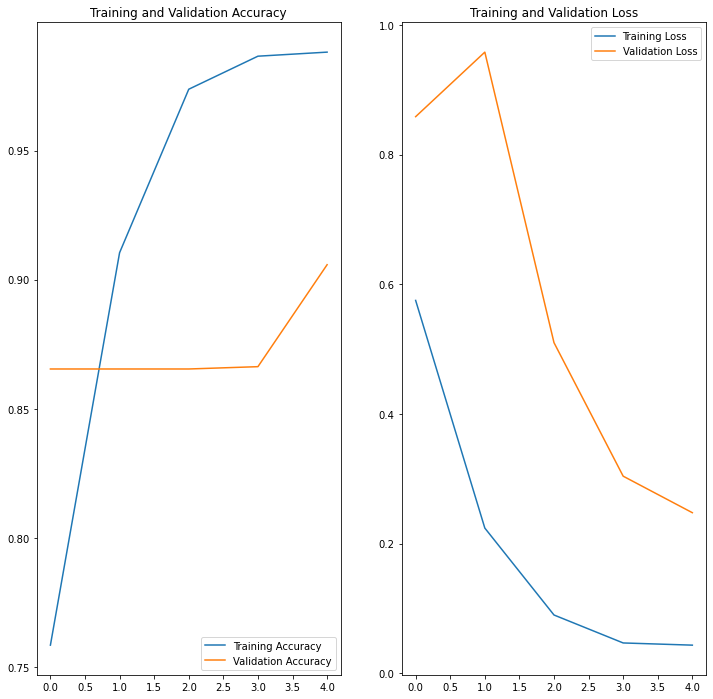

In [ ]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = 5
epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#predictions on test data
predicted=model.predict(test_data) 
predicted

array([[0.9026443 , 0.09735569],
       [0.90460527, 0.09539472],
       [0.91398156, 0.08601839],
       ...,
       [0.91751766, 0.08248238],
       [0.9030525 , 0.09694756],
       [0.9031252 , 0.09687474]], dtype=float32)

## Model Evaluation

In [ ]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: {}'.format(precision)) 
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore)) 
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test, predicted.round()))

precision: [0.90186916 1.        ]
recall: [1.  0.3]
fscore: [0.94840295 0.46153846]
support: [965 150]
############################
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       965
           1       1.00      0.30      0.46       150

   micro avg       0.91      0.91      0.91      1115
   macro avg       0.95      0.65      0.70      1115
weighted avg       0.92      0.91      0.88      1115
 samples avg       0.91      0.91      0.91      1115



## Define our RNN model

In [ ]:
#import library
from tensorflow.keras.layers import SimpleRNN
#model training
print('Training SIMPLERNN model.')

Training SIMPLERNN model.


In [ ]:
model = Sequential() 
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH ))
model.add(SimpleRNN(2, input_shape=(None,1))) 
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          2000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 2)                 206       
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
Total params: 2,000,212
Trainable params: 2,000,212
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
279/279 [==============================] - 28s 97ms/step - loss: 0.5551 - accuracy: 0.8622 - val_loss: 0.3939 - val_accuracy: 0.9094
Epoch 2/5
279/279 [==============================] - 26s 95ms/step - loss: 0.2718 - accuracy: 0.9623 - val_loss: 0.2382 - val_accuracy: 0.9552
Epoch 3/5
279/279 [==============================] - 30s 108ms/step - loss: 0.1500 - accuracy: 0.9908 - val_loss: 0.1789 - val_accuracy: 0.9587
Epoch 4/5
279/279 [==============================] - 30s 109ms/step - loss: 0.0959 - accuracy: 0.9966 - val_loss: 0.1537 - val_accuracy: 0.9641
Epoch 5/5
279/279 [==============================] - 28s 99ms/step - loss: 0.0671 - accuracy: 0.9984 - val_loss: 0.1476 - val_accuracy: 0.9614


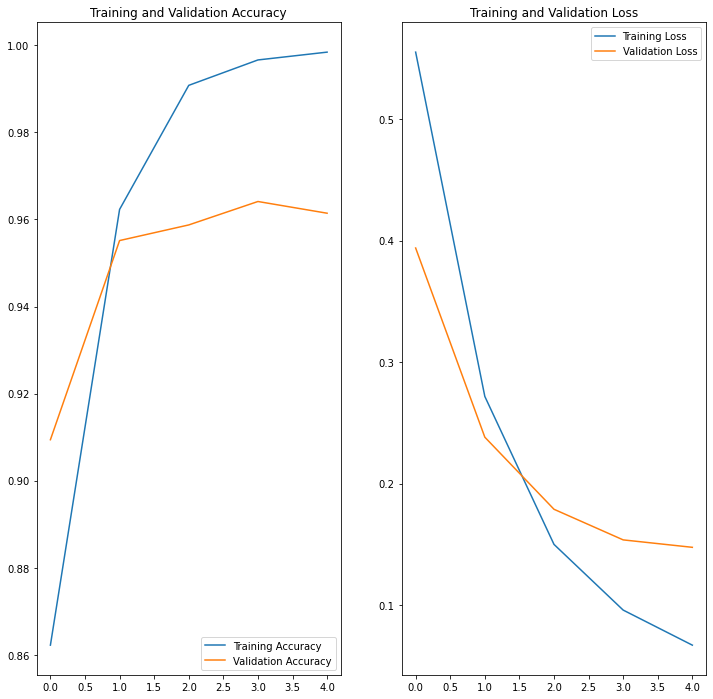

In [ ]:
history = model.fit(train_data, labels_train, batch_size=16, epochs=5,validation_data=(test_data, labels_test))

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = 5
epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# prediction on test data 
predicted_Srnn = model.predict(test_data) 
predicted_Srnn

array([[0.998591  , 0.00140901],
       [0.9984291 , 0.0015708 ],
       [0.9985154 , 0.00148456],
       ...,
       [0.9985569 , 0.0014431 ],
       [0.99859697, 0.00140303],
       [0.9985238 , 0.00147629]], dtype=float32)

In [ ]:
#model evaluation
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted_Srnn.round())
print('precision: {}'.format(precision)) 
print('recall: {}'.format(recall)) 
print('fscore: {}'.format(fscore)) 
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test, predicted_Srnn.round()))

precision: [0.95916335 0.98198198]
recall: [0.99792746 0.72666667]
fscore: [0.9781615  0.83524904]
support: [965 150]
############################
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.98      0.73      0.84       150

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115
 samples avg       0.96      0.96      0.96      1115



## Long Short-Term Memory (LSTM) Model

In [ ]:
#model training 
print('Training LSTM model.')

Training LSTM model.


In [ ]:
model = Sequential() 
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH ))
model.add(LSTM(16, activation='relu',return_sequences=True)) 
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten()) 
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          2000000   
                                                                 
 lstm (LSTM)                 (None, 300, 16)           7488      
                                                                 
 dropout_3 (Dropout)         (None, 300, 16)           0         
                                                                 
 batch_normalization_2 (Batc  (None, 300, 16)          64        
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 9602      
                                                      

Epoch 1/5
279/279 [==============================] - 47s 160ms/step - loss: 0.1417 - accuracy: 0.9522 - val_loss: 0.2120 - val_accuracy: 0.9543
Epoch 2/5
279/279 [==============================] - 43s 156ms/step - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.0827 - val_accuracy: 0.9776
Epoch 3/5
279/279 [==============================] - 40s 143ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.1084 - val_accuracy: 0.9803
Epoch 4/5
279/279 [==============================] - 41s 147ms/step - loss: 4.4249e-04 - accuracy: 1.0000 - val_loss: 0.1204 - val_accuracy: 0.9803
Epoch 5/5
279/279 [==============================] - 45s 162ms/step - loss: 2.9641e-04 - accuracy: 1.0000 - val_loss: 0.1209 - val_accuracy: 0.9821


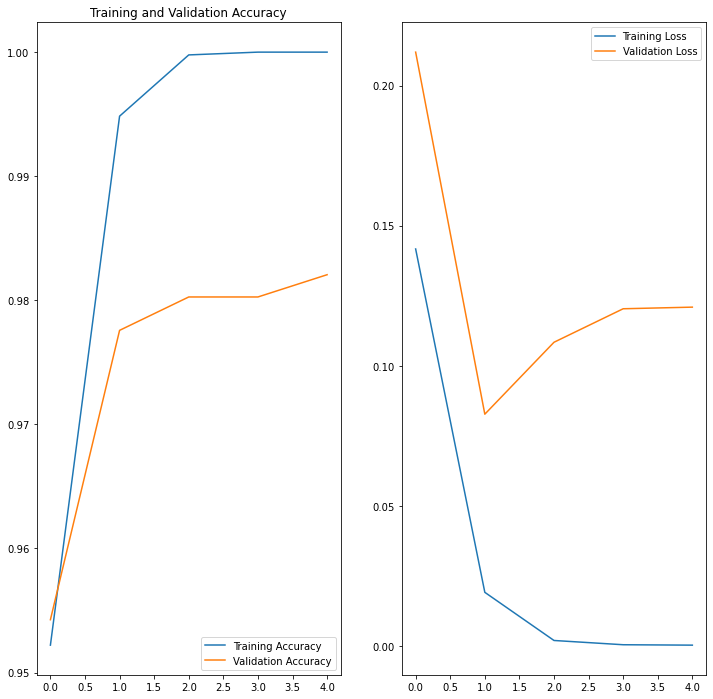

In [ ]:
history = model.fit(train_data, labels_train, batch_size=16, epochs=5, validation_data=(test_data, labels_test))
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = 5
epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
#prediction on text data 
predicted_lstm=model.predict(test_data) 
predicted_lstm

array([[1.0000000e+00, 2.1008000e-13],
       [1.0000000e+00, 3.0879543e-10],
       [1.0000000e+00, 5.2029740e-16],
       ...,
       [1.0000000e+00, 2.0635437e-18],
       [1.0000000e+00, 3.7089604e-10],
       [1.0000000e+00, 2.1025279e-09]], dtype=float32)

In [ ]:
#model evaluation
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted_lstm.round())
print('precision: {}'.format(precision)) 
print('recall: {}'.format(recall)) 
print('fscore: {}'.format(fscore)) 
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test, predicted_lstm.round()))

precision: [0.97969543 1.        ]
recall: [1.         0.86666667]
fscore: [0.98974359 0.92857143]
support: [965 150]
############################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.87      0.93       150

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115
 samples avg       0.98      0.98      0.98      1115



## Training Bidirectional LSTM model

In [ ]:
#model training
print('Training Bidirectional LSTM model.')

model = Sequential() 
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH ))
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))) 
model.add(Conv1D(16, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")) 
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation="relu")) 
model.add(Dropout(0.1))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Training Bidirectional LSTM model.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 32)          14976     
 l)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 298, 16)           1552      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 50)                850       
                                                                 
 dropout_4 (Dropout

Epoch 1/3
279/279 [==============================] - 141s 485ms/step - loss: 0.1704 - accuracy: 0.9428 - val_loss: 0.0795 - val_accuracy: 0.9785
Epoch 2/3
279/279 [==============================] - 137s 491ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.1138 - val_accuracy: 0.9785
Epoch 3/3
279/279 [==============================] - 156s 560ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 0.1175 - val_accuracy: 0.9812


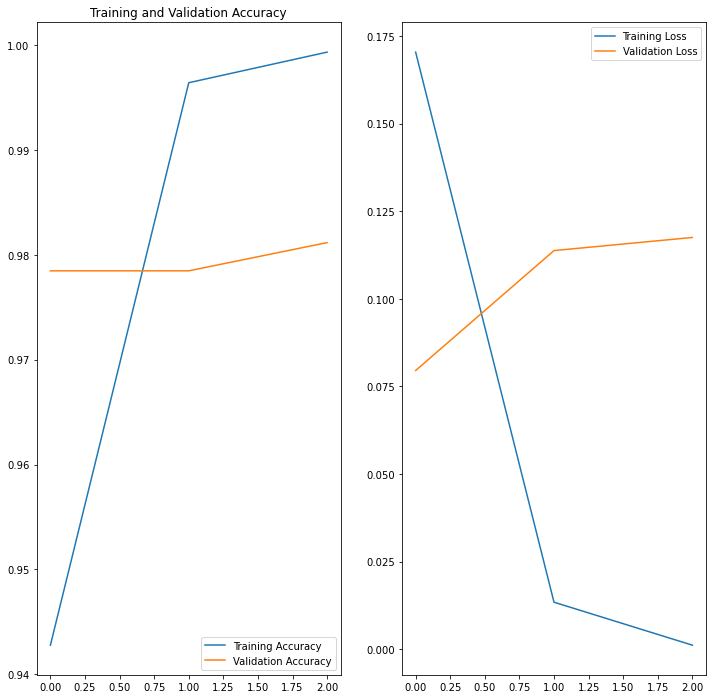

In [ ]:
history = model.fit(train_data, labels_train, batch_size=16, epochs=3, validation_data=(test_data, labels_test))

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = 3
epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
# prediction on test data
predicted_blstm=model.predict(test_data) 
predicted_blstm

array([[1.0000000e+00, 1.9096797e-13],
       [1.0000000e+00, 4.3830266e-11],
       [1.0000000e+00, 1.1373385e-11],
       ...,
       [1.0000000e+00, 3.0678782e-09],
       [1.0000000e+00, 2.8612404e-13],
       [1.0000000e+00, 2.9100290e-11]], dtype=float32)

In [ ]:
#model evaluation
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted_blstm.round())
print('precision: {}'.format(precision)) 
print('recall: {}'.format(recall)) 
print('fscore: {}'.format(fscore)) 
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test, predicted_blstm.round()))

precision: [0.98065173 0.98496241]
recall: [0.99792746 0.87333333]
fscore: [0.98921418 0.92579505]
support: [965 150]
############################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.87      0.93       150

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115
 samples avg       0.98      0.98      0.98      1115

